# Lab8 - NLP Applications: Sentiment Analysis

In this session, we will be teaching a transformer network to perform sentiment analysis using the [IMDB dataset](https://huggingface.co/datasets/stanfordnlp/imdb).

To download this dataset, we will use a library called [datasets](https://pypi.org/project/datasets/). There are other datasets available in this library that you might want to check out later.

In [ ]:
!pip install datasets

In [ ]:
import numpy as np
from numpy import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import re
from collections import Counter
from datasets import load_dataset
from sklearn.metrics import balanced_accuracy_score

# Load IMDB dataset from the datasets library
dataset = load_dataset("imdb")

## Dataset

This dataset has 25000 samples. To speed up training a little bit, we will use only 1000 (random) samples for training and validation.

In [ ]:
random.seed(534)

x = random.randint(len(dataset["train"]), size=(1000))
small_train = dataset["train"][x]
train_texts = small_train["text"]
train_labels = small_train["label"]

x = random.randint(len(dataset["test"]), size=(1000))
small_test = dataset["test"][x]
test_texts = small_test["text"]
test_labels = small_test["label"]

print(np.bincount(train_labels))
print(np.bincount(test_labels))

The code below proposes a very, very, very simple approach to creating tokens (i.e., breaking up words in the sentence). Then, we use this to create the vocabulary (based on the training data), that is, a list of all unique words.

Note that there are two special tokens: `vocab['<UNK>'] = 1` and `vocab['<PAD>'] = 0`. The first one is used to represent a word that is not in the training data, while the second one is used to pad the sentences, so they all have the same length. These are special tokens ignored in the learning process.

After that, we create a simple dataset.

In [ ]:
# Tokenization function
def simple_tokenizer(text):
    return re.findall(r'\b\w+\b', text.lower())

# Build vocabulary
counter = Counter()
for text in train_texts:
    counter.update(simple_tokenizer(text))
vocab = {word: i + 2 for i, (word, _) in enumerate(counter.most_common(2000))}  # Limit vocab size
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer):
        self.texts = [torch.tensor([vocab.get(word, vocab['<UNK>']) for word in tokenizer(text)]) for text in texts]
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = SentimentDataset(train_texts, train_labels, vocab, simple_tokenizer)
test_dataset = SentimentDataset(test_texts, test_labels, vocab, simple_tokenizer)

def collate_fn(batch):
    texts, labels = zip(*batch)
    texts = pad_sequence(texts, batch_first=True, padding_value=vocab['<PAD>']) # padding sequence
    padding_mask = (texts == vocab['<PAD>'])  # create mask to ignore the pad tokens - 1/True indicates pad, 0/False indicates not pad
    return texts, padding_mask, torch.tensor(labels)

train_dataloader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_fn)

## Model

Instead of implementing the transformer from scratch, we will use the implementation provided by Pytorch.
Precisely, the final architecture has:
- An embedding layer, to learn embeddings for the words
- The transformer encoder (image below) imported from Pytorch -- check here  [Transformer Encoder Layer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoderLayer.html) and [Transformer Encoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerEncoder.html)
- A fully connected layer to generate the final prediction

In this case, we do not need the decoder because we will not generate anything (a sentence or translation, for example). We will just capture the patterns of the sentenceand then classify it using those patterns.

However, if needed, we could use the Pytorch's [Transformer Decoder](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html) and [Transformer Decoder Layer](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoderLayer.html#torch.nn.TransformerDecoderLayer).
In fact, if that were the case, we could directly use Pytorch's [Transformers](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html).

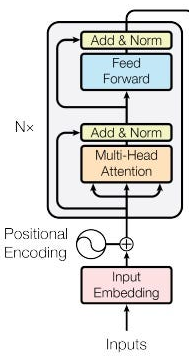

In [ ]:
# Transformer Model for Sentiment Analysis
class SentimentTransformer(nn.Module):
    def __init__(self, vocab_size, max_len=2000, embed_dim=32, num_heads=2, num_layers=2, num_classes=2):
        super(SentimentTransformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<PAD>'])
        self.position_embedding = nn.Embedding(max_len, embed_dim)
        self.pos = torch.arange(max_len).expand((1, -1))

        encoder_layers = nn.TransformerEncoderLayer(embed_dim, num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x, padding_mask):
        _, seq_length = x.shape
        x = self.embedding(x)

        position_ids = self.pos[:, : seq_length]  # get positional values
        position_embeddings = self.position_embedding(position_ids)  # generate positional emb

        x += position_embeddings
        x = x.permute(1, 0, 2) # Transformer expects (seq_len, batch, embed_dim)

        x = self.transformer_encoder(x, src_key_padding_mask=padding_mask)  # maskig out the padding tokens
        x = x.mean(dim=0)  # Global average pooling to gather general features of the input
        return self.fc(x)

# Model Setup
model = SentimentTransformer(len(vocab))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

## Training and Validation

We use to helper functions to implement the train and validation procedure.
After that, we can just train and get results.

For 5 epochs, it should take 10 minutes using CPU and produce about 60% balanced accuracy.

In [ ]:
def train(dataloader, model, criterion, optimizer):
    model.train()
    for texts, pad_mask, labels in dataloader:
        optimizer.zero_grad()
        outputs = model(texts, pad_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    bacc = balanced_accuracy_score(labels, outputs.argmax(dim=1).cpu().numpy())
    print(f"TRAIN -- Epoch {epoch+1}, Loss: {loss.item():.4f}, Balanced Accuracy: {bacc:.4f}")

def evaluate(dataloader, model):
    model.eval()
    all_preds = []
    for texts, pad_mask, labels in dataloader:
        outputs = model(texts, pad_mask)
        all_preds.append(outputs.argmax(dim=1).cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    print(f"TEST -- Balanced Accuracy: {balanced_accuracy_score(test_labels, all_preds)}")

# Training Loop
for epoch in range(5):
    train(train_dataloader, model, criterion, optimizer)
    evaluate(test_dataloader, model)